In [15]:
import os
import math
import random
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

from tqdm import tqdm

device = torch.device("cuda")

In [2]:
# Fix random seeds

seed = 42

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Dataset Implementation

In [3]:
from enum import Enum
from typing import Tuple

from torch.utils.data import Dataset, Subset, random_split


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 59:
            return cls.MIDDLE
        else:
            return cls.OLD


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2

class MaskBaseDataset(Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.data_dir = data_dir
        self.mean = mean
        self.std = std
        self.val_ratio = val_ratio

        self.transform = None
        self.setup()
        self.calc_statistics()

    def setup(self):
        profiles = os.listdir(self.data_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)
                # age_label = int(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def calc_statistics(self):
        has_statistics = self.mean is not None and self.std is not None
        if not has_statistics:
            print("[Warning] Calculating statistics... It can take a long time depending on your CPU machine")
            sums = []
            squared = []
            for image_path in self.image_paths[:3000]:
                image = np.array(Image.open(image_path)).astype(np.int32)
                sums.append(image.mean(axis=(0, 1)))
                squared.append((image ** 2).mean(axis=(0, 1)))

            self.mean = np.mean(sums, axis=0) / 255
            self.std = (np.mean(squared, axis=0) - self.mean ** 2) ** 0.5 / 255

    def set_transform(self, transform):
        self.transform = transform

    def __getitem__(self, index):
        assert self.transform is not None, ".set_tranform 메소드를 이용하여 transform 을 주입해주세요"

        image = self.read_image(index)
        mask_label = self.get_mask_label(index)
        gender_label = self.get_gender_label(index)
        age_label = self.get_age_label(index)
        multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)

        image_transform = self.transform(image)
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

    def get_mask_label(self, index) -> MaskLabels:
        return self.mask_labels[index]

    def get_gender_label(self, index) -> GenderLabels:
        return self.gender_labels[index]

    def get_age_label(self, index) -> AgeLabels:
        return self.age_labels[index]

    def read_image(self, index):
        image_path = self.image_paths[index]
        return Image.open(image_path)

    @staticmethod
    def encode_multi_class(mask_label, gender_label, age_label) -> int:
        return mask_label * 6 + gender_label * 3 + age_label

    @staticmethod
    def decode_multi_class(multi_class_label) -> Tuple[MaskLabels, GenderLabels, AgeLabels]:
        mask_label = (multi_class_label // 6) % 3
        gender_label = (multi_class_label // 3) % 2
        age_label = multi_class_label % 3
        return mask_label, gender_label, age_label

    @staticmethod
    def denormalize_image(image, mean, std):
        img_cp = image.copy()
        img_cp *= std
        img_cp += mean
        img_cp *= 255.0
        img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)
        return img_cp

    def split_dataset(self) -> Tuple[Subset, Subset]:
        """
        데이터셋을 train 과 val 로 나눕니다,
        pytorch 내부의 torch.utils.data.random_split 함수를 사용하여
        torch.utils.data.Subset 클래스 둘로 나눕니다.
        구현이 어렵지 않으니 구글링 혹은 IDE (e.g. pycharm) 의 navigation 기능을 통해 코드를 한 번 읽어보는 것을 추천드립니다^^
        """
        n_val = int(len(self) * self.val_ratio)
        n_train = len(self) - n_val
        train_set, val_set = random_split(self, [n_train, n_val])
        return train_set, val_set

In [4]:
from typing import List
from collections import defaultdict

from torch.utils.data import Subset

class SplitByProfileDataset(MaskBaseDataset):
    """
        train / val 나누는 기준을 이미지에 대해서 random 이 아닌
        사람(profile)을 기준으로 나눕니다.
        구현은 val_ratio 에 맞게 train / val 나누는 것을 이미지 전체가 아닌 사람(profile)에 대해서 진행하여 indexing 을 합니다
        이후 `split_dataset` 에서 index 에 맞게 Subset 으로 dataset 을 분기합니다.
    """

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.indices = defaultdict(list)
        super().__init__(data_dir, mean, std, val_ratio)

    @staticmethod
    def _split_profile(profiles, val_ratio):
        length = len(profiles)
        n_val = int(length * val_ratio)

        val_indices = set(random.choices(range(length), k=n_val))
        train_indices = set(range(length)) - val_indices
        return {
            "train": train_indices,
            "val": val_indices
        }

    def setup(self):
        profiles = os.listdir(self.data_dir)
        profiles = [profile for profile in profiles if not profile.startswith(".")]
        split_profiles = self._split_profile(profiles, self.val_ratio)

        cnt = 0
        for phase, indices in split_profiles.items():
            for _idx in indices:
                profile = profiles[_idx]
                img_folder = os.path.join(self.data_dir, profile)
                for file_name in os.listdir(img_folder):
                    _file_name, ext = os.path.splitext(file_name)
                    if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                        continue

                    img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                    mask_label = self._file_names[_file_name]

                    id, gender, race, age = profile.split("_")
                    gender_label = GenderLabels.from_str(gender)
                    age_label = AgeLabels.from_number(age)

                    self.image_paths.append(img_path)
                    self.mask_labels.append(mask_label)
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

                    self.indices[phase].append(cnt)
                    cnt += 1

    def split_dataset(self) -> List[Subset]:
        return [Subset(self, indices) for phase, indices in self.indices.items()]

## Load Pretrained Model

In [5]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained("efficientnet-b2")

Loaded pretrained weights for efficientnet-b2


In [6]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [7]:
from efficientnet_pytorch import EfficientNet

class CustomEfficientNet(nn.Module):
    def __init__(self, device, num_features = 18, dropout_p = 0.6):
        super().__init__()
        
        if device is None:
            self.effnet = EfficientNet.from_pretrained("efficientnet-b2")
        else:
            self.effnet = EfficientNet.from_pretrained("efficientnet-b2").to(device)
        self.pool   = nn.AdaptiveAvgPool2d(output_size = 1)
        self.drop   = nn.Dropout2d(dropout_p)
        self.dense  = nn.Linear(1408, num_features)

        for param in self.effnet.parameters():
            param.require_grads = False
            # freezing all params
        
    def forward(self, x):
        # x.shape == torch.Size([B, 3, 224, 224])
        x = self.effnet.extract_features(x)
        x = self.pool(x)
        x = self.drop(x)
        x = x.flatten(start_dim = 1)
        # print(x.shape)
        x = self.dense(x)
        return x

In [26]:
model = CustomEfficientNet(device, 18, 0.6).to(device)

Loaded pretrained weights for efficientnet-b2


In [27]:
randimg = torch.randn(1, 3, 244, 244).to(device)
out = model(randimg)

In [28]:
out.shape

torch.Size([1, 18])

In [29]:
mask_ds = SplitByProfileDataset("input/data/train/images")

transform = T.Compose([T.Resize((224, 224)),
                       T.RandomHorizontalFlip(),
                       T.ToTensor(),
                       T.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246))])

mask_ds.set_transform(transform)

In [30]:
train_ds, valid_ds = mask_ds.split_dataset()

BATCH_SIZE = 64
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle=False)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=5e-3)

In [32]:
NUM_EPOCHS = 10
EVERY = 20   # scheduler step

losses = []
accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    idx = 0
    for img, lbl in tqdm(train_dl):
        img = img.to(device)
        lbl = lbl.to(device)
        
        optimizer.zero_grad()
        
        out = model(img)
        loss = criterion(out, lbl)
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(out, dim = -1)
        accuracy = torch.sum(pred == lbl) / lbl.size(0)
        
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
        idx += 1
        
#         if (idx+1) % EVERY == 0:
#             scheduler.step()
#             print(scheduler.get_last_lr())
        
    print("Epoch {} : loss {}, accuracy {}".format(epoch, np.mean(losses[-idx:]), np.mean(accuracies[-idx:])))
    
    idx = 0
    for img, lbl in tqdm(valid_dl):
        
        with torch.no_grad():
            img = img.to(device)
            lbl = lbl.to(device)
            
            out = model(img)
            loss = criterion(out, lbl)
        
            _, pred = torch.max(out, dim = -1)
            accuracy = torch.sum(pred == lbl) / lbl.size(0)
        
        val_losses.append(loss.item())
        val_accuracies.append(accuracy.item())
        
        idx += 1
    
    print("Validation : loss {}, accuracy {}".format(np.mean(val_losses[-idx:]), np.mean(val_accuracies[-idx:])))

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 0 : loss 1.0711025761776283, accuracy 0.6862690688156691


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 0.8027755708064673, accuracy 0.7278891509433962


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 : loss 0.3762496081409884, accuracy 0.8770278347808806


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 0.7409039367482347, accuracy 0.7576650943396226


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 : loss 0.23852233060437147, accuracy 0.9181608606557377


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 0.7745729628598915, accuracy 0.7744693396226415


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3 : loss 0.16821264393139082, accuracy 0.9424166097992757


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 0.8242394797644526, accuracy 0.7691627358490566


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4 : loss 0.11656579837111421, accuracy 0.9617059426229508


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 0.9145742041181844, accuracy 0.7780070754716981


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5 : loss 0.08329412228137743, accuracy 0.9738587204550133


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 0.9655968951729109, accuracy 0.7788915094339622


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6 : loss 0.06615651223510809, accuracy 0.9793658925861609


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 0.958760899474036, accuracy 0.7824292452830188


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7 : loss 0.05763661503013162, accuracy 0.9830231102275067


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 1.0214298041361682, accuracy 0.7794811320754716


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8 : loss 0.04535653693296137, accuracy 0.9856486225225887


  0%|          | 0/244 [00:00<?, ?it/s]

Validation : loss 1.0558546586137898, accuracy 0.7777122641509434


  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9 : loss 0.031136470912673252, accuracy 0.9917392418032787


100%|██████████| 53/53 [00:23<00:00,  2.26it/s]

Validation : loss 1.1263874275785573, accuracy 0.7774174528301887


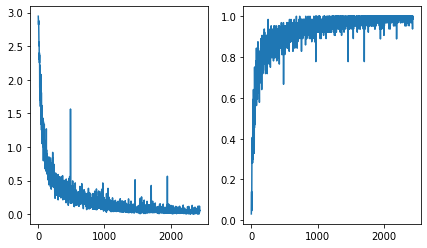

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].plot(losses)
ax[1].plot(accuracies)

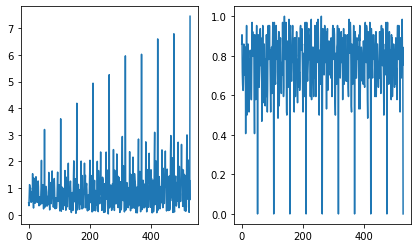

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].plot(val_losses)
ax[1].plot(val_accuracies)

In [35]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [36]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir = "input/data/eval"
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = T.Compose([
    T.Resize((224, 224), Image.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    batch_size = 128,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        out = model(images)
        _, pred = torch.max(out, dim = -1)
        
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


test inference is done!


In [37]:
# Confirm Test Result
data_dir = os.path.join(test_dir, "submission.csv")
results = pd.read_csv(data_dir)
results.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,14
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12


In [38]:
results['ans'].value_counts()

0     2337
2     1777
4     1538
3     1452
1     1320
5      509
6      482
12     472
14     332
8      332
7      323
13     316
10     310
9      298
15     292
16     283
11     119
17     108
Name: ans, dtype: int64

In [45]:
row = 3
col = 6
ans = 6
start_idx = 0
corrects = 0

subset = results.loc[results["ans"] == ans, :]
subset = subset.sample(frac=1).reset_index(drop = True)
subset.head()

,ImageID,ans
0,92c3050368919b0660320d707d365ced1cc62cb2.jpg,6
1,3467024299ecd61666d0b8e53999f6c1fe645158.jpg,6
2,d505ed5d51b61827d09bfa052b5478a0078e4e80.jpg,6
3,c3f1815b112e71f2e0faa92773662933d522329c.jpg,6
4,20f8b496101fe551dc78c852c292be94e5deffab.jpg,6


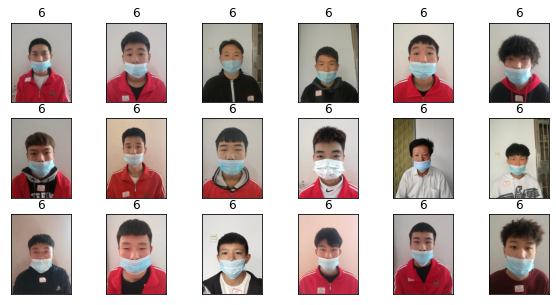

Continue? Type # of correct images!  16


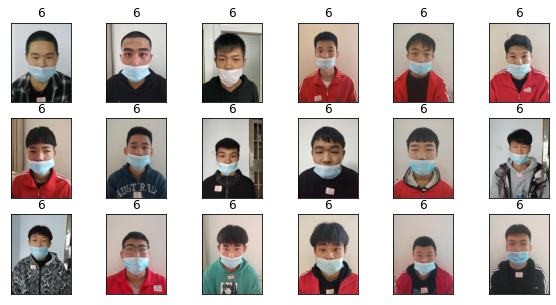

In [ ]:
while True:
    fig, axes = plt.subplots(row, col, figsize=(10, 5))
    samples = subset.sample(n = row * col)
    for i in range(row):
        for j in range(col):
            idx = i * col + j
            img_dir = os.path.join(test_dir, "images", samples.ImageID.iloc[idx])
            img = Image.open(img_dir)
            axes[i][j].imshow(img)
            axes[i][j].set_title(str(samples.ans.iloc[idx]))
            axes[i][j].xaxis.set_visible(False)
            axes[i][j].yaxis.set_visible(False)
    plt.show()
    response = input("Continue? Type # of correct images! ")
    if response == "0":
        break
    else:
        corrects += int(response)
        start_idx += 1
print(corrects)
print(start_idx)

![img](https://s3-ap-northeast-2.amazonaws.com/aistages-public-junyeop/app/Users/00000025/files/56bd7d05-4eb8-4e3e-884d-18bd74dc4864..png)